In [1]:
#neccessary imports
import matplotlib.pyplot as plt
import math
import numpy as np
import scipy as sp
import qmcpy as qp
from scipy import stats
import sympy as sy
import sympy.stats
from scipy.stats import norm

$Y = f(X_1, X_2, X_3) = X_1 + X_2 + X_3$ for $X_j \sim \mathcal{U}(0, 2^{j-1})$
\
\
$Y = \mathcal{U}([0,1]) + 2\mathcal{U}([0,1]) + 4\mathcal{U}([0,1])$
\
\
$\rho_{\text{true}}(y) = \text{big piecewise function of lines, parabolas}$
\
\
$\rho(y | \mathcal{G}_{-k}) = \text{piecewise between constant and 0}$


In [19]:
#EXAMPLE 1: weighted sum of uniforms

def theFunc(u):
    return u[0] + 2*u[1] + 4*u[2]

def truePDF(y):
    n = len(y)
    output = [0.0] * n
    for i in range(n):
        if y[i] < 1 and y[i] > 0:
            output[i] = (1 / 16) * y[i]**2
        elif y[i] < 2 and y[i] > 1:
            output[i] = (1 / 16) + (1 / 8) * (y[i] - 1)
        elif y[i] < 3 and y[i] > 2:
            output[i] = (3 / 16) + (3 / 8) * (y[i] - 2) - (1 / 16) * (y[i]**2 - 4)
        elif y[i] < 4 and y[i] > 3:
            output[i] = 1/4
        elif y[i] < 5 and y[i] > 4:
            output[i] = (3 / 16) + (1 / 16) * (1 - (y[i] - 4)**2)
        elif y[i] < 6 and y[i] > 5:
            output[i] = (1 / 16) + (1 / 8) * (6 - y[i])
        elif y[i] < 7 and y[i] > 6:
            output[i] = (3 / 8) * (7 - y[i]) - (1 / 16) *(9 - (y[i] - 4)**2)
        else:
            output[i] = 0
    return output

def conditionalDensity1(y, x):
    test = y - x[1] - x[2]
    for j in range(len(test)):
        if test[j] > 0 and test[j] < 1:
            test[j] = 1
        else:
            test[j] = 0
    return test

def conditionalDensity2(y, x):
    test = y - x[0] - x[2]
    for j in range(len(test)):
        if test[j] > 0 and test[j] < 2:
            test[j] = 1/2
        else:
            test[j] = 0
    return test

def conditionalDensity3(y, x):
    test = y - x[0] - x[1]
    for j in range(len(test)):
        if test[j] > 0 and test[j] < 4:
            test[j] = 1/4
        else:
            test[j] = 0
    return test

#inverseCDFs expect only between (0, 1)
def inverseCDF1(y):
    return y

def inverseCDF2(y):
    return 2*y

def inverseCDF3(y):
    return 4*y


inverseCDFs = [inverseCDF1, inverseCDF2, inverseCDF3]
conditionalDensities = [conditionalDensity1, conditionalDensity2, conditionalDensity3]
start, end = 0, 7
Q = 25.5323059457 #take bandwidth = (Q / n) **(1/5) generally


$Y = f(X_1, X_2, X_3, X_4) = \frac{1}{\alpha}(\sum_{i=1}^4 X_i) = \frac{1}{\alpha}(\sum_{i=1}^4 w_i Z_i)$ for $\alpha^2 = \sum_{i=1}^4 w_i^2$
\
\
$\rho_{\text{true}}(y) = \phi(x)$
\
\
$\rho(y | \mathcal{G}_{-k}) = \frac{\alpha}{w_k}\phi(\frac{1}{w_k}(\alpha y - \sum_{i\neq k}^4 X_i))$

In [8]:
#EXAMPLE 2: weighted sum of normals

weights = np.array([0.0625, 0.125, 0.25, 0.5])
alpha = np.sqrt(np.sum(weights * weights))

def theFunc(u):
    return np.sum((weights / alpha) * norm.ppf(u))

def truePDF(y):
    return norm.pdf(y)

def conditionalDensity1(y, x):
    return (alpha / weights[0]) * norm.pdf((1 / weights[0]) * (alpha*y - (np.sum(x, 0) - x[0])))

def conditionalDensity2(y, x):
    return (alpha / weights[1]) * norm.pdf((1 / weights[1]) * (alpha*y - (np.sum(x, 0) - x[1])))

def conditionalDensity3(y, x):
    return (alpha / weights[2]) * norm.pdf((1 / weights[2]) * (alpha*y - (np.sum(x, 0) - x[2])))

def conditionalDensity4(y, x):
    return (alpha / weights[3]) * norm.pdf((1 / weights[3]) * (alpha*y - (np.sum(x, 0) - x[3])))

#inverseCDFs expect only between (0, 1)
def inverseCDF1(y):
    return weights[0] * norm.ppf(y)

def inverseCDF2(y):
    return weights[1] * norm.ppf(y)

def inverseCDF3(y):
    return weights[2] * norm.ppf(y)

def inverseCDF4(y):
    return weights[3] * norm.ppf(y)


inverseCDFs = [inverseCDF1, inverseCDF2, inverseCDF3, inverseCDF4]
conditionalDensities = [conditionalDensity1, conditionalDensity2, conditionalDensity3, conditionalDensity4]
start, end = -3, 3
Q = 25.5323059457 #take bandwidth = (Q / n) **(1/5) generally


In [3]:
def kernelDensityEstimator(y, pointSet, bandwidth): 
    n = len(pointSet)
    def gaussianKernel(z):
         return np.exp(-z**2) / math.sqrt(math.pi)
    sum = 0
    for i in range(n):
        sum += (1 / (n*bandwidth)) * gaussianKernel((y - theFunc(pointSet[i])) / bandwidth)
    return sum

def conditionalEstimator(y, conditionalDensity, realizations):
    output = 0
    for j in range(realizations[:, 0].size):
        output += conditionalDensity(y, realizations[j]) / realizations[:, 0].size
    return output

In [4]:
def getErrorofDVariables(pointSetType, n, method, conditionalDensity, bandwidth, inverseCDFs):
    nError = 100
    errorPoints = np.linspace(start, end, nError)

    dimension = len(inverseCDFs)
    if n <= 0:
        raise Exception("n must be a positive integer")
    
    if pointSetType == "MC":
        pointSet = qp.IIDStdUniform(dimension).gen_samples(n)
    elif pointSetType == "Sobol":
        pointSet = qp.Sobol(dimension).gen_samples(n)
    else:
        raise Exception("Currently supported pointSetTypes are MC and Sobol")
    if method == "KDE":
        evaluatedPoints = kernelDensityEstimator(errorPoints, pointSet, bandwidth)
    elif method == "conditional":
        realizations = np.array([[0.0] * dimension] * n)
        for i in range(dimension):
            realizations[:, i] = inverseCDFs[i](pointSet[:, i])
        evaluatedPoints = conditionalEstimator(errorPoints, conditionalDensity, realizations)
    else:
        raise Exception("Valid methods are KDE or conditional")
    estimatedError = ((end - start) / nError) * np.sum((evaluatedPoints - truePDF(errorPoints))**2)
    return estimatedError

def averageErrorLog(pointSetType, n, method, conditionalDensity, bandwidth, inverseCDFs, averageAcross):
    sum = 0
    for i in range(averageAcross):
        sum += (1 / averageAcross) * getErrorofDVariables(pointSetType, n, method, conditionalDensity, bandwidth, inverseCDFs)
    return -np.log10(sum)



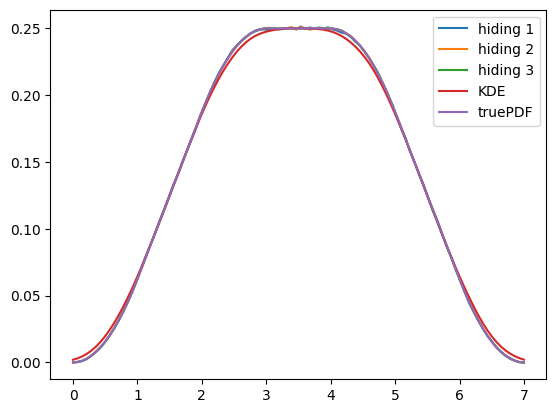

In [22]:
n = 2**12
nEval = 100
evalPoints = np.linspace(start, end, nEval)
fig, ax = plt.subplots()

dimension = len(inverseCDFs)
sobolPoints = qp.Sobol(dimension).gen_samples(n)

realizations = np.array([[0.0] * dimension] * n)
evaluatedPoints = [0.0] * dimension
for i in range(dimension):
    realizations[:, i] = inverseCDFs[i](sobolPoints[:, i])
for i in range(dimension):
    evaluatedPoints[i] = conditionalEstimator(evalPoints, conditionalDensities[i], realizations)


truePoints = truePDF(evalPoints)

bandwidth = (Q / n) **(1/5)
KDEPoints = kernelDensityEstimator(evalPoints, sobolPoints, bandwidth)

for i in range(dimension):
    ax.plot(evalPoints, evaluatedPoints[i], label = f"hiding {i + 1}")
ax.plot(evalPoints, KDEPoints, label = "KDE")
ax.plot(evalPoints, truePoints, label = "truePDF")
legend = ax.legend()

In [110]:
for method in ["conditional", "KDE"]:
        for pointSetType in ["MC", "Sobol"]:
                if method == "conditional":
                        for conditionalDensity in conditionalDensities:
                                output = []
                                for exp in range(10, 15, 2):
                                        output.append(averageErrorLog(pointSetType, 2**exp, method, 
                                                                      conditionalDensity, "no bandwidth", inverseCDFs, 10))
                                print(pointSetType, method, conditionalDensity.__name__, output)
                if method == "KDE":
                        output = []
                        for exp in range(10, 15, 2):
                                output.append(averageErrorLog(pointSetType, 2**exp, method, 
                                                                      "no conditional density", (Q / (2**exp))**(1/5), inverseCDFs, 10))
                        print(pointSetType, method, output)

MC conditional conditionalDensity1 [3.9192424049558863, 4.386825268078777, 5.15757790280878]
MC conditional conditionalDensity2 [4.351288916759869, 4.7130296180901174, 5.2970948455158915]
Sobol conditional conditionalDensity1 [7.648631804829083, 8.881101753516871, 10.221939689779708]
Sobol conditional conditionalDensity2 [8.314952818665763, 9.402815270665213, 10.712625917624406]
MC KDE [2.898211374504158, 3.400729788444614, 3.839041245852223]
Sobol KDE [3.227310532965775, 3.6802864934988024, 4.151239414579234]


In [121]:
def printErrorTable(methods, pointSetTypes, conditionalDensities, start, stop, increment, averageOver):
    for method in methods:
        if method == "conditional":
            for conditionalDensity in conditionalDensities:
                for pointSetType in pointSetTypes:
                    output = []
                    for exp in range(start, stop, increment):
                        output.append(averageErrorLog(pointSetType, 2**exp, method, conditionalDensity, "N/A bandwidth", inverseCDFs, averageOver))
                    print(pointSetType, method, conditionalDensity.__name__, output)
        elif method == "KDE":
            for pointSetType in pointSetTypes:
                output = []
                for exp in range(start, stop, increment):
                    output.append(averageErrorLog(pointSetType, 2**exp, method, "no conditional density", bandwidth, inverseCDFs, averageOver))
                print(pointSetType, method, output)

In [122]:
printErrorTable(["conditional", "KDE"], ["MC", "Sobol"], conditionalDensities, 10, 15, 2, 10)

MC conditional conditionalDensity1 [2.617879300952935, 3.3072538439757526, 3.7998254806014526]
Sobol conditional conditionalDensity1 [3.007264978610068, 4.057054028550916, 5.130233066130109]
MC conditional conditionalDensity2 [3.1094240661621178, 3.635325108400806, 4.208268181408212]
Sobol conditional conditionalDensity2 [4.176425164534532, 5.257119627352564, 6.469013789313355]
MC conditional conditionalDensity3 [3.435783407373207, 4.129425629212683, 4.696084578181218]
Sobol conditional conditionalDensity3 [5.773733713525263, 7.092452836346658, 8.11732008556629]
MC conditional conditionalDensity4 [4.397414660716252, 5.150937080288053, 5.421046483511871]
Sobol conditional conditionalDensity4 [7.566497752932477, 8.906234785008207, 10.160284593271411]
MC KDE [2.998969562076241, 3.2957400752213433, 3.7906425283333247]
Sobol KDE [3.543389691263512, 4.015368858160239, 4.131750289979764]
